In [70]:
# Cell 1: Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
import time
from abc import ABC, abstractmethod
from math import atan2, cos, sin, sqrt, pi
import logging  # For better debugging
from typing import Optional, Tuple, List  # For type hints

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [81]:
# Cell 2: Classes and Utility Functions

# Face Detection Abstract Base Class
class FaceDetector(ABC):
    @abstractmethod
    def changeOrientationUntilFaceFound(self, image: np.ndarray, rot_interval: int) -> Tuple[np.ndarray, Optional[Tuple[int, int, int, int]]]:
        pass

    @abstractmethod
    def findFace(self, img: np.ndarray) -> Tuple[float, Optional[Tuple[int, int, int, int]]]:
        pass

    @abstractmethod
    def rotate_bound(self, image: np.ndarray, angle: float) -> np.ndarray:
        pass

# SSD Face Detector Implementation
class SsdFaceDetector(FaceDetector):
    def __init__(self, confidence_threshold: float = 0.2):
        self.model_dir = "models"
        self.modelFile = os.path.join(self.model_dir, "res10_300x300_ssd_iter_140000.caffemodel")
        self.configFile = os.path.join(self.model_dir, "deploy.prototxt.txt")
        self.confidence_threshold = confidence_threshold
        
        model_file_exists = os.path.isfile(self.modelFile)
        config_file_exists = os.path.isfile(self.configFile)
        logging.info(f"Checking model files in {self.model_dir}:")
        logging.info(f"  - {self.modelFile} exists: {model_file_exists}")
        logging.info(f"  - {self.configFile} exists: {config_file_exists}")
        
        if not model_file_exists or not config_file_exists:
            raise FileNotFoundError(f"Model files not found in {self.model_dir}")

    def changeOrientationUntilFaceFound(self, image: np.ndarray, rot_interval: int) -> Tuple[np.ndarray, Optional[Tuple[int, int, int, int]]]:
        img = image.copy()
        face_conf = []
        for angle in range(0, 360, rot_interval):
            img_rotated = self.rotate_bound(img, angle)
            confidence, face_box = self.findFace(img_rotated)
            face_conf.append((confidence, angle, face_box))
            logging.info(f"Angle: {angle}°, Confidence: {confidence:.2f}")
        face_confidence = np.array(face_conf, dtype=object)
        face_arg_max = np.argmax(face_confidence[:, 0])
        angle_max = face_confidence[face_arg_max][1]
        max_confidence = face_confidence[face_arg_max][0]
        best_face_box = face_confidence[face_arg_max][2]
        logging.info(f"Max confidence: {max_confidence:.2f} at angle: {angle_max}°")
        rotated_img = self.rotate_bound(image, angle_max)
        return rotated_img, best_face_box if max_confidence > self.confidence_threshold else (None, None)

    def findFace(self, img: np.ndarray) -> Tuple[float, Optional[Tuple[int, int, int, int]]]:
        try:
            FaceNet = cv2.dnn.readNetFromCaffe(self.configFile, self.modelFile)
        except cv2.error as e:
            logging.error(f"Failed to load FaceNet model: {e}")
            return 0, None

        h, w = img.shape[:2]
        img_resized = cv2.resize(img, (300, 300))
        img_enhanced = cv2.convertScaleAbs(img_resized, alpha=1.5, beta=0)
        blob = cv2.dnn.blobFromImage(img_enhanced, 1.0, (300, 300), (104.0, 117.0, 123.0))
        FaceNet.setInput(blob)
        faces = FaceNet.forward()
        for i in range(faces.shape[2]):
            confidence = faces[0, 0, i, 2]
            if confidence > 0:
                x1 = int(faces[0, 0, i, 3] * w)
                y1 = int(faces[0, 0, i, 4] * h)
                x2 = int(faces[0, 0, i, 5] * w)
                y2 = int(faces[0, 0, i, 6] * h)
                logging.info(f"Face detected with confidence: {confidence:.2f} at (x1={x1}, y1={y1}, x2={x2}, y2={y2})")
                return confidence, (x1, y1, x2, y2)
        logging.info("No face detected with confidence above 0")
        return 0, None

    def rotate_bound(self, image: np.ndarray, angle: float) -> np.ndarray:
        (h, w) = image.shape[:2]
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
        cos_val = np.abs(M[0, 0])
        sin_val = np.abs(M[0, 1])
        nW = int((h * sin_val) + (w * cos_val))
        nH = int((h * cos_val) + (w * sin_val))
        M[0, 2] += (nW / 2) - cX
        M[1, 2] += (nH / 2) - cY
        return cv2.warpAffine(image, M, (nW, nH))

# Face Factory
class FaceFactory(ABC):
    @abstractmethod
    def get_face_detector(self) -> FaceDetector:
        pass

class SsdModel(FaceFactory):
    def get_face_detector(self) -> FaceDetector:
        return SsdFaceDetector(confidence_threshold=0.2)

def face_factory(face_model: str = "ssd", confidence_threshold: float = 0.2) -> FaceFactory:
    factories = {"ssd": SsdModel()}
    return factories[face_model]

# Utility Functions
class UnetModel:
    def __init__(self, backbone, device):
        self.backbone = backbone
        self.device = device

    def predict(self, img: np.ndarray) -> np.ndarray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Enhance contrast using CLAHE
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(16, 16))  # Increased clipLimit
        gray_enhanced = clahe.apply(gray)
        # Denoise the image
        gray_denoised = cv2.GaussianBlur(gray_enhanced, (5, 5), 0)
        # Use adaptive thresholding for text detection
        thresh = cv2.adaptiveThreshold(
            gray_denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 21, 5  # Adjusted for better text detection
        )
        # Morphological operations to connect text and reduce noise
        kernel = np.ones((7, 7), np.uint8)  # Further increased kernel size
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=7)  # Increased iterations
        cleaned = cv2.dilate(cleaned, kernel, iterations=3)  # Increased dilation
        return cleaned

class Res34BackBone:
    pass

def correctPerspective(img: np.ndarray) -> np.ndarray:
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_green = np.array([10, 10, 10])
    upper_green = np.array([110, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    card_mask = cv2.bitwise_not(mask)
    card_img = cv2.bitwise_and(img, img, mask=card_mask)
    
    gray = cv2.cvtColor(card_img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray_enhanced = clahe.apply(gray)
    edges = cv2.Canny(gray_enhanced, 15, 60, apertureSize=3)
    kernel = np.ones((5, 5), np.uint8)
    edges_dilated = cv2.dilate(edges, kernel, iterations=3)
    cntrs, _ = cv2.findContours(edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cntrs:
        logging.warning("No contours found for perspective correction")
        return img
    
    candidates = []
    min_area = 5000
    for cnt in cntrs:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            candidates.append((approx, area))
    
    if not candidates:
        logging.warning("No quadrilateral found, using largest contour")
        largest_contour = max(cntrs, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        padding = 5
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(img.shape[1] - x, w + 2 * padding)
        h = min(img.shape[0] - y, h + 2 * padding)
        return img[y:y+h, x:x+w]
    
    candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
    approx = candidates[0][0]
    x, y, w, h = cv2.boundingRect(approx)
    warped = warpImg(img, approx, w, h)
    
    gray_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray_warped, 25, 255, cv2.THRESH_BINARY)
    cntrs, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cntrs:
        largest_contour = max(cntrs, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        padding = 5
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(warped.shape[1] - x, w + 2 * padding)
        h = min(warped.shape[0] - y, h + 2 * padding)
        return warped[y:y+h, x:x+w]
    return warped

def reorder(myPoints: np.ndarray) -> np.ndarray:
    myPointsNew = np.zeros_like(myPoints)
    myPoints = myPoints.reshape((4, 2))
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

def warpImg(img: np.ndarray, points: np.ndarray, w: int, h: int) -> np.ndarray:
    points = reorder(points)
    pts1 = np.float32(points)
    pts2 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(img, matrix, (w, h))

def findOrientationofLines(mask: np.ndarray) -> float:
    cntrs, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cntrs) == 0:
        logging.warning("No contours found for orientation detection")
        return 0
    
    largest_contour = max(cntrs, key=cv2.contourArea)
    if cv2.contourArea(largest_contour) < 500:
        logging.warning("Largest contour too small for orientation detection")
        return 0
    
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[2]
    width = rect[1][0]
    height = rect[1][1]
    aspect_ratio = max(width, height) / min(width, height) if min(width, height) > 0 else 1
    
    if aspect_ratio > 1.2:
        if width < height:
            angle = 90 - angle if angle < 45 else -angle
    angle = ((angle + 90) % 180) - 90
    return angle

def rotateImage(orientation_angle: float, final_img: np.ndarray) -> np.ndarray:
    (h, w) = final_img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), orientation_angle, 1.0)
    return cv2.warpAffine(final_img, M, (w, h))

def displayAllBoxes(img: np.ndarray, rect: List[Tuple[int, int, int, int]]) -> np.ndarray:
    for rct in rect:
        x1, w, y1, h = rct
        cv2.rectangle(img, (x1, y1), (x1+w, y1+h), (255, 0, 0), 2)
        cX = round(int(x1) + w/2.0)
        cY = round(int(y1) + h/2.0)
        cv2.circle(img, (cX, cY), 3, (0, 255, 0), -1)
    return img

def displayMachedBoxes(img: np.ndarray, new_bboxes: List[Tuple[int, int, int, int]]) -> np.ndarray:
    for box in new_bboxes:
        x1, w, y1, h = box
        cv2.rectangle(img, (x1, y1), (x1 + w, y1 + h), (0, 0, 255), 3)
        cX = round(int(x1) + w / 2.0)
        cY = round(int(y1) + h / 2.0)
        cv2.circle(img, (cX, cY), 7, (0, 255, 255), -1)
    return img

def createHeatMapAndBoxCoordinates(image: np.ndarray) -> Tuple[np.ndarray, List[Tuple[int, int, int, int, int, int, int, int]]]:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(16, 16))
    gray_enhanced = clahe.apply(gray)
    gray_denoised = cv2.GaussianBlur(gray_enhanced, (5, 5), 0)
    _, thresh = cv2.threshold(gray_denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((7, 7), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    thresh = cv2.dilate(thresh, kernel, iterations=3)
    cntrs, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 10  # Further reduced
    max_area = 0.1 * image.shape[0] * image.shape[1]
    boxes = []
    for cnt in cntrs:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h > 0 else 0
        if min_area < area < max_area and 0.05 < aspect_ratio < 20.0:  # Further widened
            boxes.append((x, y, w, h))
            logging.debug(f"Box detected: x={x}, y={y}, w={w}, h={h}, area={area}, aspect_ratio={aspect_ratio:.2f}")
        else:
            logging.debug(f"Box filtered out: area={area}, aspect_ratio={aspect_ratio:.2f}")
    if not boxes:
        logging.warning("No boxes detected in createHeatMapAndBoxCoordinates")
    else:
        logging.info(f"Detected {len(boxes)} boxes in createHeatMapAndBoxCoordinates")
    return thresh, [(x, y, x+w, y, x, y+h, x+w, y+h) for x, y, w, h in boxes]

def getCenterRatios(img: np.ndarray, centers: np.ndarray) -> np.ndarray:
    if len(img.shape) == 2:
        img_h, img_w = img.shape
    else:
        img_h, img_w, _ = img.shape
    if img_h == 0 or img_w == 0:
        logging.error("Image dimensions are zero")
        return np.array([])
    ratios = np.zeros_like(centers, dtype=np.float32)
    for i, center in enumerate(centers):
        ratios[i] = (center[0]/img_w, center[1]/img_h)
    return ratios

def matchCenters(ratios1: np.ndarray, ratios2: np.ndarray) -> np.ndarray:
    num_regions = min(len(ratios1), len(ratios2))
    if num_regions == 0:
        logging.warning("No regions to match in matchCenters")
        return np.array([])
    
    distances = np.zeros((num_regions, len(ratios2)))
    for i, r1 in enumerate(ratios1[:num_regions]):
        for j, r2 in enumerate(ratios2):
            distances[i, j] = np.sum(np.abs(r1 - r2))
    
    matched_indices = []
    for i in range(num_regions):
        if i >= distances.shape[0] or i >= distances.shape[1]:
            break
        min_idx = np.argmin(distances[i])
        matched_indices.append(min_idx)
        distances[:, min_idx] = np.inf
    
    return np.array(matched_indices, dtype=int)

def getCenterOfMasks(thresh: np.ndarray) -> np.ndarray:
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        logging.warning("No contours found in getCenterOfMasks")
        return np.array([(0, 0)])
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    detected_centers = []
    min_area = 5  # Further reduced
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_area:
            logging.debug(f"Contour filtered out in getCenterOfMasks: area={area}")
            continue
        (x, y, w, h) = cv2.boundingRect(contour)
        cX = round(int(x) + w/2.0)
        cY = round(int(y) + h/2.0)
        detected_centers.append((cX, cY))
        logging.debug(f"Mask center detected: cX={cX}, cY={cY}, area={area}")
    if not detected_centers:
        logging.warning("No valid centers found after filtering in getCenterOfMasks")
        return np.array([(0, 0)])
    logging.info(f"Detected {len(detected_centers)} centers in getCenterOfMasks")
    return np.array(detected_centers)

def getBoxRegions(regions: List[Tuple[int, int, int, int, int, int, int, int]]) -> Tuple[np.ndarray, np.ndarray]:
    boxes = []
    centers = []
    for box_region in regions:
        x1, y1, x2, y2, x3, y3, x4, y4 = box_region
        x = min(x1, x3)
        y = min(y1, y2)
        w = abs(min(x1, x3) - max(x2, x4))
        h = abs(min(y1, y2) - max(y3, y4))
        cX = round(int(x) + w/2.0)
        cY = round(int(y) + h/2.0)
        centers.append((cX, cY))
        bbox = (int(x), w, int(y), h)
        boxes.append(bbox)
    if not boxes:
        logging.warning("No boxes generated in getBoxRegions")
    return np.array(boxes), np.array(centers)

2025-03-16 22:49:56,129 - INFO - Images folder found at: input
2025-03-16 22:49:56,131 - INFO - Found image files: ['sample2.jpg']
2025-03-16 22:49:56,132 - INFO - Checking model files in models:
2025-03-16 22:49:56,134 - INFO -   - models\res10_300x300_ssd_iter_140000.caffemodel exists: True
2025-03-16 22:49:56,134 - INFO -   - models\deploy.prototxt.txt exists: True
2025-03-16 22:49:57,287 - INFO - Saved original image plot to: preprocessed\original_sample2.jpg


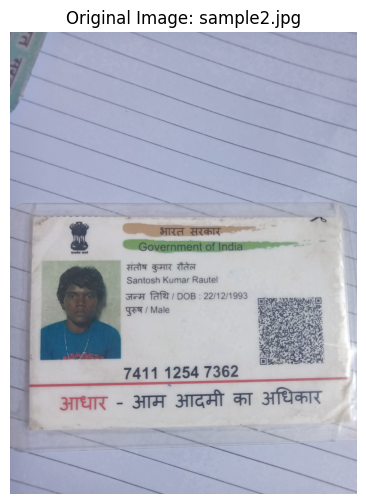

2025-03-16 22:49:57,995 - INFO - Face detected with confidence: 0.37 at (x1=474, y1=2227, x2=768, y2=2639)
2025-03-16 22:49:58,001 - INFO - Face detected in initial orientation with confidence: 0.37
2025-03-16 22:49:58,385 - INFO - Additional rotation of -90.00 degrees applied after perspective correction
2025-03-16 22:49:58,582 - INFO - Detected 2 boxes in createHeatMapAndBoxCoordinates
2025-03-16 22:49:59,109 - INFO - Saved heatmap to: preprocessed\heatmap_sample2.jpg
2025-03-16 22:50:02,711 - INFO - Saved predicted mask plot to: preprocessed\predicted_mask_sample2.jpg


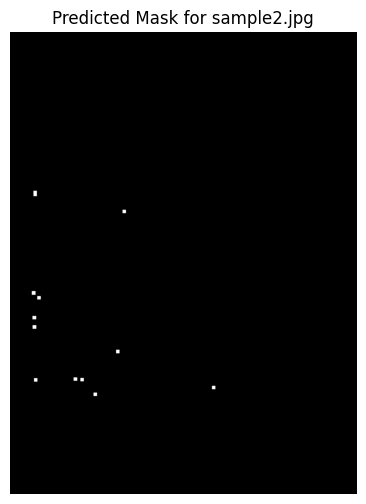

2025-03-16 22:50:04,810 - INFO - Computed Orientation of ID Card is -90.00 degrees
2025-03-16 22:50:04,813 - INFO - Absolute orientation angle (90.00) is greater than ORI_THRESH (1)
2025-03-16 22:50:04,863 - INFO - Total rotation applied: -90.00 degrees
2025-03-16 22:50:04,994 - INFO - Detected 6 boxes in createHeatMapAndBoxCoordinates
2025-03-16 22:50:05,881 - INFO - Saved after rotation image plot to: preprocessed\after_rotation_img_sample2.jpg


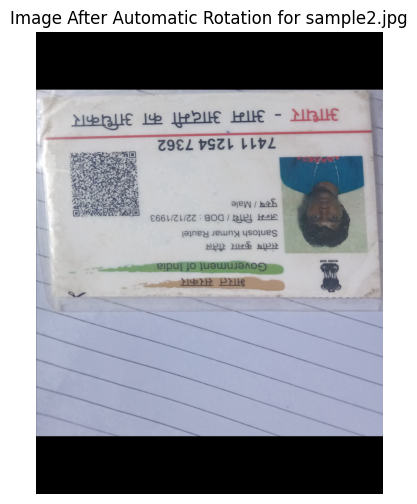

2025-03-16 22:50:08,365 - INFO - Saved after rotation mask plot to: preprocessed\after_rotation_mask_sample2.jpg


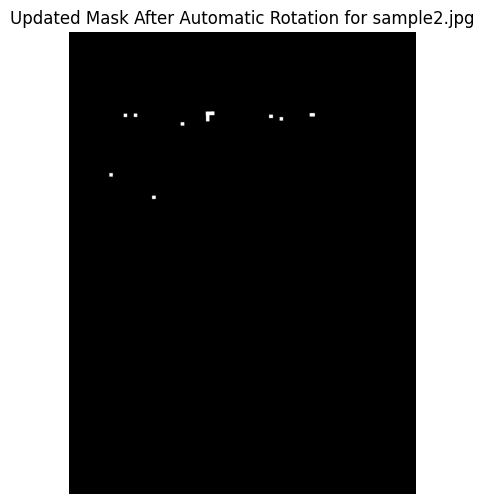

2025-03-16 22:50:09,613 - INFO - Detected 9 centers in getCenterOfMasks
2025-03-16 22:50:09,615 - INFO - Matched 6 boxes
2025-03-16 22:50:10,355 - INFO - Saved processed with boxes plot to: preprocessed\processed_with_boxes_sample2.jpg


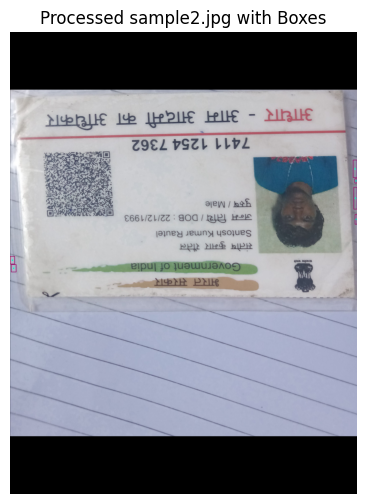

2025-03-16 22:50:12,896 - INFO - Saved final predicted mask plot to: preprocessed\final_mask_sample2.jpg


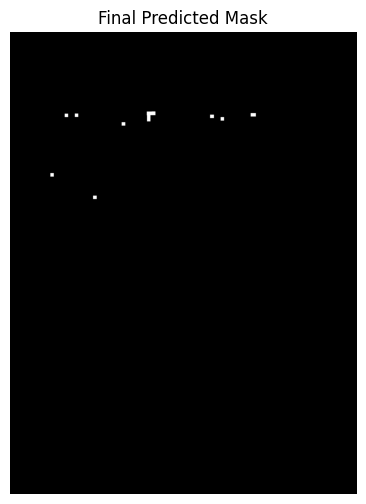

2025-03-16 22:50:14,198 - INFO - Saved final processed image to: output\processed_sample2.jpg
2025-03-16 22:50:14,200 - INFO - Detected 6 boxes in sample2.jpg:
2025-03-16 22:50:14,200 - INFO - Box 1: x=11, y=2093, width=44, height=67
2025-03-16 22:50:14,201 - INFO - Box 2: x=1, y=2019, width=41, height=69
2025-03-16 22:50:14,202 - INFO - Box 3: x=3102, y=1643, width=18, height=87
2025-03-16 22:50:14,203 - INFO - Box 4: x=3091, y=1397, width=29, height=197
2025-03-16 22:50:14,205 - INFO - Box 5: x=3100, y=1320, width=20, height=40
2025-03-16 22:50:14,206 - INFO - Box 6: x=3085, y=1152, width=35, height=158
2025-03-16 22:50:14,207 - INFO - Execution Time: 18.071107864379883 seconds


In [83]:
# Cell 3: Main Processing Loop

# Configuration
folder_name = "input"
rotation_interval = 10
ORI_THRESH = 1
use_cuda = "cuda" if torch.cuda.is_available() else "cpu"
confidence_threshold = 0.2

# Check if images folder exists
if not os.path.isdir(folder_name):
    logging.error(f"Images folder not found at {folder_name}")
    absolute_folder = os.path.join(os.getcwd(), folder_name)
    if not os.path.isdir(absolute_folder):
        logging.error(f"Absolute path {absolute_folder} also not found")
        raise FileNotFoundError(f"Images folder not found: {absolute_folder}")
    else:
        folder_name = absolute_folder
        logging.info(f"Using absolute path: {folder_name}")
else:
    logging.info(f"Images folder found at: {folder_name}")
    image_files = [f for f in os.listdir(folder_name) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    logging.info(f"Found image files: {image_files}")

# Initialize components
face_detector = face_factory(face_model="ssd", confidence_threshold=confidence_threshold).get_face_detector()
model = UnetModel(Res34BackBone(), use_cuda)

# Create output directory if it doesn't exist
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    logging.info(f"Created output directory at: {output_dir}")

# Create preprocessed directory if it doesn't exist
preprocessed_dir = "preprocessed"
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)
    logging.info(f"Created preprocessed directory at: {preprocessed_dir}")

# Process images
start = time.time()
for filename in sorted(os.listdir(folder_name)):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img_path = os.path.join(folder_name, filename)
    img = cv2.imread(img_path)
    if img is None:
        logging.error(f"Failed to load {filename} from {img_path}")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Show and save original image
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(f"Original Image: {filename}")
    plt.axis("off")
    original_plot_path = os.path.join(preprocessed_dir, f"original_{filename}")
    plt.savefig(original_plot_path, bbox_inches='tight', dpi=300)
    logging.info(f"Saved original image plot to: {original_plot_path}")
    plt.show()
    plt.close()

    # Step 1: Face Detection and Orientation
    initial_confidence, initial_face_box = face_detector.findFace(img_rgb)
    if initial_confidence > confidence_threshold:
        logging.info(f"Face detected in initial orientation with confidence: {initial_confidence:.2f}")
        final_img = img_rgb.copy()
        best_face_box = initial_face_box
    else:
        logging.info("No face detected in initial orientation, trying rotations...")
        final_img, best_face_box = face_detector.changeOrientationUntilFaceFound(img_rgb, rotation_interval)
        if final_img is None:
            logging.error(f"No face detected in identity card {filename} even after rotation")
            continue
    
    # Enforce horizontal orientation based on face detection
    if best_face_box:
        x1, y1, x2, y2 = best_face_box
        face_width = x2 - x1
        face_height = y2 - y1
        if face_height > face_width * 1.5:
            final_img = face_detector.rotate_bound(final_img, 90)
            logging.info("Rotated 90 degrees based on face orientation")

    # Step 2: Perspective Correction
    final_img = correctPerspective(final_img)

    # Additional orientation check after perspective correction
    gray = cv2.cvtColor(final_img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
    cntrs, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cntrs:
        largest_contour = max(cntrs, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)
        angle = rect[2]
        width, height = rect[1]
        if height > width * 1.5:
            angle = (angle + 90) % 180
        angle = ((angle + 90) % 180) - 90
        if abs(angle) > ORI_THRESH:
            final_img = rotateImage(angle, final_img)
            logging.info(f"Additional rotation of {angle:.2f} degrees applied after perspective correction")

    # Step 3: Segmentation and Orientation Correction
    txt_heat_map, regions = createHeatMapAndBoxCoordinates(final_img)
    txt_heat_map = cv2.cvtColor(txt_heat_map, cv2.COLOR_GRAY2RGB)
    predicted_mask = model.predict(final_img)

    # Save the heatmap for debugging
    heatmap_path = os.path.join(preprocessed_dir, f"heatmap_{filename}")
    cv2.imwrite(heatmap_path, txt_heat_map)
    logging.info(f"Saved heatmap to: {heatmap_path}")

    # Show and save predicted mask
    plt.figure(figsize=(8, 6))
    plt.imshow(predicted_mask, cmap="gray")
    plt.title(f"Predicted Mask for {filename}")
    plt.axis("off")
    predicted_mask_path = os.path.join(preprocessed_dir, f"predicted_mask_{filename}")
    plt.savefig(predicted_mask_path, bbox_inches='tight', dpi=300)
    logging.info(f"Saved predicted mask plot to: {predicted_mask_path}")
    plt.show()
    plt.close()

    # Track cumulative rotation
    total_rotation = 0

    # Automatic orientation correction
    orientation_angle = findOrientationofLines(predicted_mask.copy())
    logging.info(f"Computed Orientation of ID Card is {orientation_angle:.2f} degrees")
    if abs(orientation_angle) > ORI_THRESH:
        logging.info(f"Absolute orientation angle ({abs(orientation_angle):.2f}) is greater than ORI_THRESH ({ORI_THRESH})")
        final_img = rotateImage(orientation_angle, final_img)
        total_rotation += orientation_angle
        logging.info(f"Total rotation applied: {total_rotation:.2f} degrees")
        txt_heat_map, regions = createHeatMapAndBoxCoordinates(final_img)
        txt_heat_map = cv2.cvtColor(txt_heat_map, cv2.COLOR_GRAY2RGB)
        predicted_mask = model.predict(final_img)
        # Show and save image after rotation
        plt.figure(figsize=(8, 6))
        plt.imshow(final_img)
        plt.title(f"Image After Automatic Rotation for {filename}")
        plt.axis("off")
        after_rotation_img_path = os.path.join(preprocessed_dir, f"after_rotation_img_{filename}")
        plt.savefig(after_rotation_img_path, bbox_inches='tight', dpi=300)
        logging.info(f"Saved after rotation image plot to: {after_rotation_img_path}")
        plt.show()
        plt.close()
        # Show and save updated mask after rotation
        plt.figure(figsize=(8, 6))
        plt.imshow(predicted_mask, cmap="gray")
        plt.title(f"Updated Mask After Automatic Rotation for {filename}")
        plt.axis("off")
        after_rotation_mask_path = os.path.join(preprocessed_dir, f"after_rotation_mask_{filename}")
        plt.savefig(after_rotation_mask_path, bbox_inches='tight', dpi=300)
        logging.info(f"Saved after rotation mask plot to: {after_rotation_mask_path}")
        plt.show()
        plt.close()

    # Step 4: Detect and Match Bounding Boxes
    bbox_coordinates, box_centers = getBoxRegions(regions)
    mask_centers = getCenterOfMasks(predicted_mask)
    centers_ratio_mask = getCenterRatios(predicted_mask, mask_centers)
    centers_ratio_all = getCenterRatios(final_img, box_centers)

    matched_box_indexes = matchCenters(centers_ratio_mask, centers_ratio_all)
    if len(matched_box_indexes) > 0 and len(bbox_coordinates) > 0:
        new_bboxes = bbox_coordinates[matched_box_indexes]
        logging.info(f"Matched {len(new_bboxes)} boxes")
    else:
        logging.warning("No matched boxes found. Using all detected boxes.")
        new_bboxes = bbox_coordinates

    # Step 5: Visualization
    final_img_with_matched_boxes = displayMachedBoxes(final_img.copy(), new_bboxes)
    final_img_with_all_boxes = displayAllBoxes(final_img_with_matched_boxes.copy(), bbox_coordinates)

    # Show and save processed image with boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(final_img_with_all_boxes)
    plt.title(f"Processed {filename} with Boxes")
    plt.axis("off")
    processed_with_boxes_path = os.path.join(preprocessed_dir, f"processed_with_boxes_{filename}")
    plt.savefig(processed_with_boxes_path, bbox_inches='tight', dpi=300)
    logging.info(f"Saved processed with boxes plot to: {processed_with_boxes_path}")
    plt.show()
    plt.close()

    # Show and save final predicted mask
    plt.figure(figsize=(8, 6))
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Final Predicted Mask")
    plt.axis("off")
    final_mask_path = os.path.join(preprocessed_dir, f"final_mask_{filename}")
    plt.savefig(final_mask_path, bbox_inches='tight', dpi=300)
    logging.info(f"Saved final predicted mask plot to: {final_mask_path}")
    plt.show()
    plt.close()

    # Step 6: Save the Final Processed Image to 'output' directory
    output_filename = os.path.join(output_dir, f"processed_{filename}")
    final_img_with_all_boxes_bgr = cv2.cvtColor(final_img_with_all_boxes, cv2.COLOR_RGB2BGR)
    success = cv2.imwrite(output_filename, final_img_with_all_boxes_bgr)
    if success:
        logging.info(f"Saved final processed image to: {output_filename}")
    else:
        logging.error(f"Failed to save final processed image to: {output_filename}")

    logging.info(f"Detected {len(bbox_coordinates)} boxes in {filename}:")
    for i, (x, w, y, h) in enumerate(bbox_coordinates):
        logging.info(f"Box {i+1}: x={x}, y={y}, width={w}, height={h}")

end = time.time()
logging.info(f"Execution Time: {end - start} seconds")